# Loading Libraries

In [2]:
# -----------------------
# Imports
# -----------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [82]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Loading data

In [4]:
# -----------------------
# Load Data
# -----------------------
df_train = pd.read_parquet('train.parquet')
df_test = pd.read_parquet('test.parquet')
df_sample_submission = pd.read_parquet('sample_submission.parquet')

In [5]:
# -----------------------
# Initial Data Overview
# -----------------------
print("Train Shape:", df_train.shape)
print("Test Shape:", df_test.shape)
print("Sample Submission Shape:", df_sample_submission.shape)
print("\nTarget Distribution:")
print(df_train['target'].value_counts())

Train Shape: (1639424, 7)
Test Shape: (409856, 7)
Sample Submission Shape: (50, 2)

Target Distribution:
target
0    1625386
1      14038
Name: count, dtype: int64


In [6]:
# -----------------------
# Convert Target to Integer
# -----------------------
df_train['target'] = df_train['target'].astype(int)

# -----------------------
# Convert Date & Extract Features
# -----------------------
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train['day'] = df_train['Date'].dt.day
df_train['month'] = df_train['Date'].dt.month
df_train['year'] = df_train['Date'].dt.year
df_train['dayofweek'] = df_train['Date'].dt.dayofweek
df_train['is_weekend'] = (df_train['dayofweek'] >= 5).astype(int)

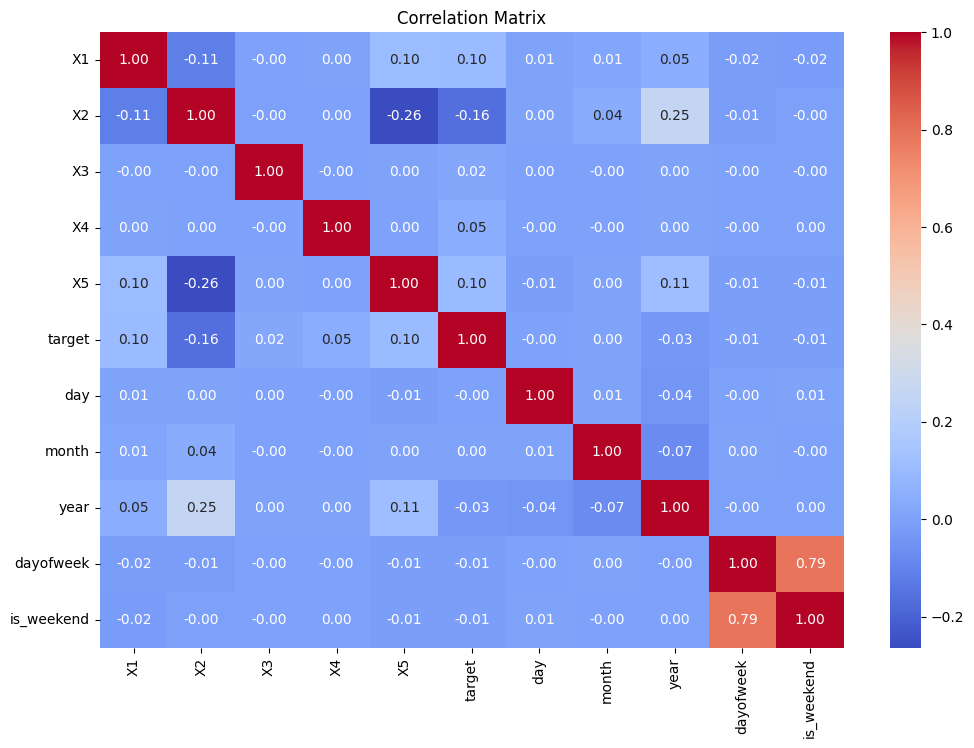

In [7]:
# -----------------------
# Correlation Matrix
# -----------------------
df_numeric = df_train.select_dtypes(include='number')
corr_matrix = df_numeric.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [8]:
# Sorted Correlation with Target
target_corr = corr_matrix['target'].sort_values(ascending=False)
print("\nSorted Correlation with Target:")
print(target_corr)


Sorted Correlation with Target:
target        1.000000
X5            0.098049
X1            0.096103
X4            0.045209
X3            0.018852
month         0.002298
day          -0.002198
is_weekend   -0.008537
dayofweek    -0.008692
year         -0.033140
X2           -0.163221
Name: target, dtype: float64


# Feature Selection and Scaling

In [10]:
# -----------------------
# Feature Selection
# -----------------------
features_to_drop = ['month', 'day', 'is_weekend', 'dayofweek', 'year']
X = df_numeric.drop(columns=['target'] + features_to_drop)
y = df_numeric['target']

In [11]:
# -----------------------
# Scale Features
# -----------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------
# Handle Class Imbalance
# -----------------------
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_scaled, y)
print("\nResampled Target Distribution:")
print(pd.Series(y_resampled).value_counts())

# -----------------------
# Train-Test Split
# -----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)


Resampled Target Distribution:
target
0    14038
1    14038
Name: count, dtype: int64


# Basic Machine Learning Models

#Logistic Regression

In [16]:
# Initialize and train model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [17]:
# Predict and evaluate
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1 Score (macro):", f1_score(y_test, y_pred_lr, average='macro'))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

Logistic Regression Performance:
Accuracy: 0.8709045584045584
F1 Score (macro): 0.8708930597472839
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      2808
           1       0.86      0.88      0.87      2808

    accuracy                           0.87      5616
   macro avg       0.87      0.87      0.87      5616
weighted avg       0.87      0.87      0.87      5616



 # Support Vector Machine (SVM)

In [18]:
# Initialize and train model
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [19]:
# Predict and evaluate
y_pred_svm = svm_model.predict(X_test)
print("Support Vector Machine Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("F1 Score (macro):", f1_score(y_test, y_pred_svm, average='macro'))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

Support Vector Machine Performance:
Accuracy: 0.8701923076923077
F1 Score (macro): 0.8701567010321049
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.85      0.87      2808
           1       0.86      0.89      0.87      2808

    accuracy                           0.87      5616
   macro avg       0.87      0.87      0.87      5616
weighted avg       0.87      0.87      0.87      5616



# K-Nearest Neighbors (KNN)

In [20]:
# Initialize and train model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [21]:
# Predict and evaluate
y_pred_knn = knn_model.predict(X_test)
print("K-Nearest Neighbors Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("F1 Score (macro):", f1_score(y_test, y_pred_knn, average='macro'))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))

K-Nearest Neighbors Performance:
Accuracy: 0.8668091168091168
F1 Score (macro): 0.8667976968585731
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.87      2808
           1       0.86      0.88      0.87      2808

    accuracy                           0.87      5616
   macro avg       0.87      0.87      0.87      5616
weighted avg       0.87      0.87      0.87      5616



#  Decision Tree

In [22]:
# Initialize and train model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [23]:
# Predict and evaluate
y_pred_dt = dt_model.predict(X_test)
print("Decision Tree Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("F1 Score (macro):", f1_score(y_test, y_pred_dt, average='macro'))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))

Decision Tree Performance:
Accuracy: 0.8326210826210826
F1 Score (macro): 0.832619363145441
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.84      0.83      2808
           1       0.83      0.83      0.83      2808

    accuracy                           0.83      5616
   macro avg       0.83      0.83      0.83      5616
weighted avg       0.83      0.83      0.83      5616



# Ensemble Methods

#  Random Forest

In [29]:
# Initialize and train model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [30]:
# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1 Score (macro):", f1_score(y_test, y_pred_rf, average='macro'))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Performance:
Accuracy: 0.8628917378917379
F1 Score (macro): 0.8628771123574854
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86      2808
           1       0.86      0.87      0.86      2808

    accuracy                           0.86      5616
   macro avg       0.86      0.86      0.86      5616
weighted avg       0.86      0.86      0.86      5616



# LightGBM

In [31]:
# Initialize and train model
lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 11230, number of negative: 11230
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 639
[LightGBM] [Info] Number of data points in the train set: 22460, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(random_state=42)

In [32]:
# Predict and evaluate
y_pred_lgbm = lgbm_model.predict(X_test)
print("LightGBM Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print("F1 Score (macro):", f1_score(y_test, y_pred_lgbm, average='macro'))
print("Classification Report:\n", classification_report(y_test, y_pred_lgbm))

LightGBM Performance:
Accuracy: 0.9082977207977208
F1 Score (macro): 0.9082961826824356
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.91      2808
           1       0.90      0.91      0.91      2808

    accuracy                           0.91      5616
   macro avg       0.91      0.91      0.91      5616
weighted avg       0.91      0.91      0.91      5616



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


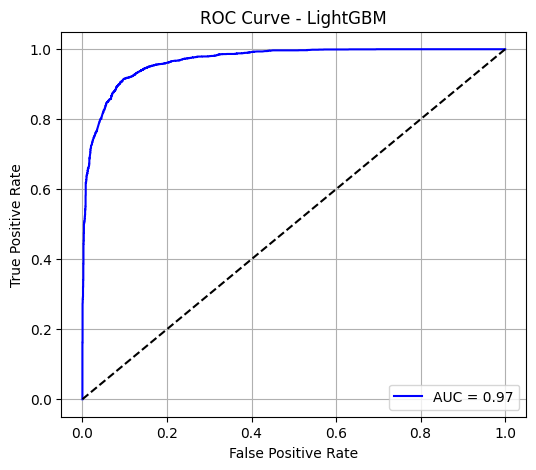

In [74]:
# Get predicted probabilities on X_test
y_probs_lgbm = lgbm_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_probs_lgbm)
auc_lgbm = auc(fpr_lgbm, tpr_lgbm)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr_lgbm, tpr_lgbm, color='blue', label=f'AUC = {auc_lgbm:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

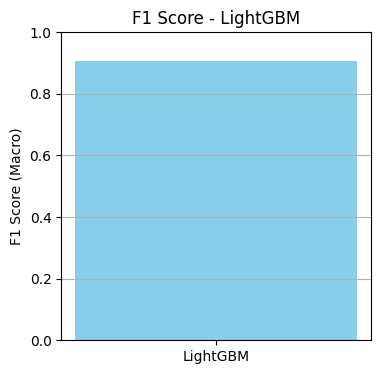

In [75]:
# Compute F1 Score
f1_lgbm = f1_score(y_test, y_pred_lgbm, average='macro')

# Plot
plt.figure(figsize=(4, 4))
plt.bar(['LightGBM'], [f1_lgbm], color='skyblue')
plt.ylabel('F1 Score (Macro)')
plt.title('F1 Score - LightGBM')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

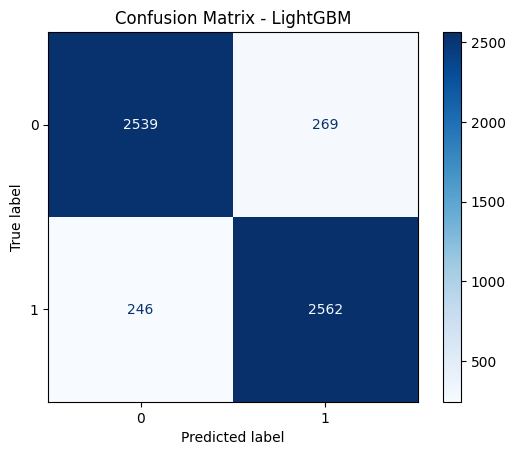

In [77]:
# Compute and display confusion matrix
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
disp_lgbm = ConfusionMatrixDisplay(confusion_matrix=cm_lgbm, display_labels=[0, 1])
disp_lgbm.plot(cmap='Blues')
plt.title("Confusion Matrix - LightGBM")
plt.grid(False)
plt.show()

#XGBoost

In [12]:
# -----------------------
# Train XGBoost
# -----------------------
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:17:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [13]:
# -----------------------
# Predict and Evaluate
# -----------------------
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:, 1]

print("\nXGBoost Model Performance (Default Threshold):")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
print("Classification Report:\n", classification_report(y_test, y_pred))


XGBoost Model Performance (Default Threshold):
Accuracy: 0.8847934472934473
F1 Score (macro): 0.8847889724696354
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.88      2808
           1       0.88      0.89      0.89      2808

    accuracy                           0.88      5616
   macro avg       0.88      0.88      0.88      5616
weighted avg       0.88      0.88      0.88      5616



##### Used threshold = 0.3 instead of 0.5 due to class imbalance. It improved recall and F1-score for the minority class by reducing false negatives.

In [14]:
# -----------------------
# Tune Prediction Threshold
# -----------------------
threshold = 0.3
y_pred_adjusted = (y_probs >= threshold).astype(int)

print(f"\nXGBoost Performance (Threshold = {threshold}):")
print("Accuracy:", accuracy_score(y_test, y_pred_adjusted))
print("F1 Score (macro):", f1_score(y_test, y_pred_adjusted, average='macro'))
print("Classification Report:\n", classification_report(y_test, y_pred_adjusted))


XGBoost Performance (Threshold = 0.3):
Accuracy: 0.8682336182336182
F1 Score (macro): 0.8674638362621678
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.79      0.86      2808
           1       0.82      0.94      0.88      2808

    accuracy                           0.87      5616
   macro avg       0.88      0.87      0.87      5616
weighted avg       0.88      0.87      0.87      5616



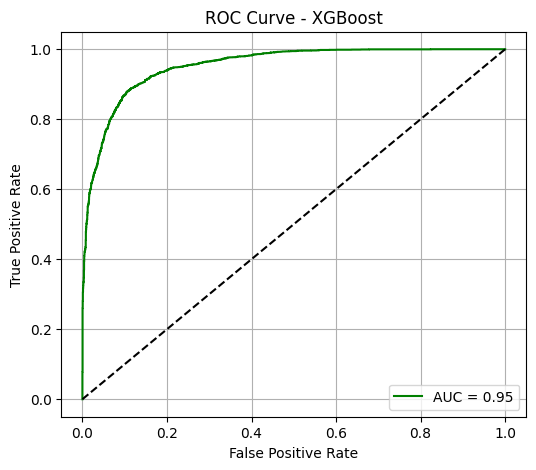

In [79]:
# Compute ROC curve and AUC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_probs)
auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr_xgb, tpr_xgb, color='green', label=f'AUC = {auc_xgb:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

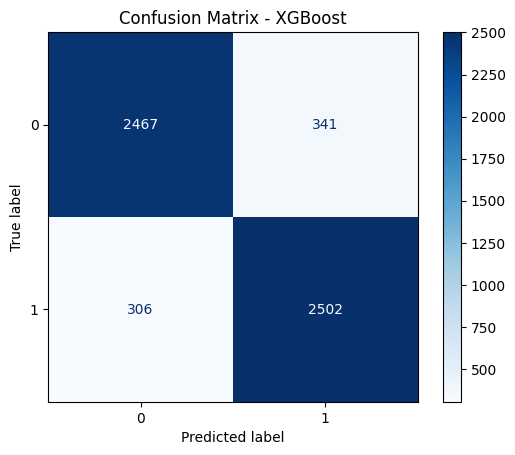

In [80]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.grid(False)
plt.show()

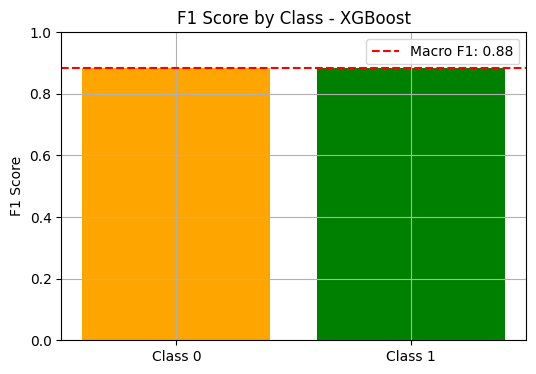

In [81]:
# Macro F1
f1_macro = f1_score(y_test, y_pred, average='macro')

# Class-wise F1 scores
f1_classwise = f1_score(y_test, y_pred, average=None)

# Bar chart
plt.figure(figsize=(6, 4))
plt.bar(['Class 0', 'Class 1'], f1_classwise, color=['orange', 'green'])
plt.axhline(f1_macro, color='red', linestyle='--', label=f'Macro F1: {f1_macro:.2f}')
plt.ylabel("F1 Score")
plt.title("F1 Score by Class - XGBoost")
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.show()

# Deep Learing Model

In [35]:
# Build the model
dl_model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
dl_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = dl_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8176 - loss: 0.4136 - val_accuracy: 0.8702 - val_loss: 0.3123
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8691 - loss: 0.3113 - val_accuracy: 0.8713 - val_loss: 0.3090
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8638 - loss: 0.3201 - val_accuracy: 0.8693 - val_loss: 0.3074
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8692 - loss: 0.3076 - val_accuracy: 0.8716 - val_loss: 0.3056
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8687 - loss: 0.3079 - val_accuracy: 0.8716 - val_loss: 0.3055
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8702 - loss: 0.3072 - val_accuracy: 0.8727 - val_loss: 0.3028
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8690 - loss: 0.3078 - val_accuracy: 0.8722 - val_loss: 0.3020
Epoch 8/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8682 - loss: 0.3058 - val_accuracy: 0.

In [36]:
# Predict probabilities and convert using threshold
y_probs_dl = dl_model.predict(X_test).flatten()
threshold = 0.3
y_pred_dl = (y_probs_dl >= threshold).astype(int)

# Evaluate
print("Deep Learning Model Performance (Threshold = 0.3):")
print("Accuracy:", accuracy_score(y_test, y_pred_dl))
print("F1 Score (macro):", f1_score(y_test, y_pred_dl, average='macro'))
print("Classification Report:\n", classification_report(y_test, y_pred_dl))

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Deep Learning Model Performance (Threshold = 0.3):
Accuracy: 0.8555911680911681
F1 Score (macro): 0.854550661654909
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.77      0.84      2808
           1       0.80      0.94      0.87      2808

    accuracy                           0.86      5616
   macro avg       0.87      0.86      0.85      5616
weighted avg       0.87      0.86      0.85      5616



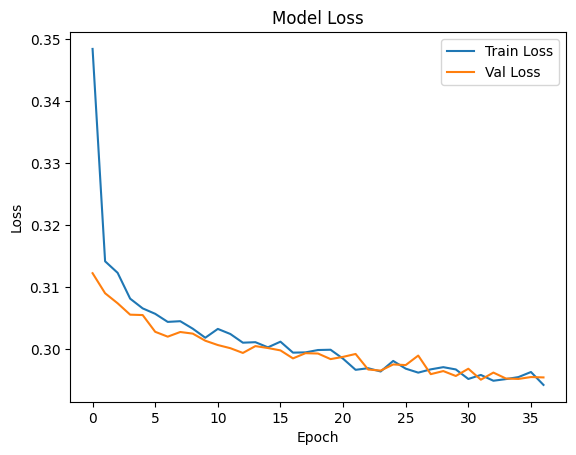

In [37]:
# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

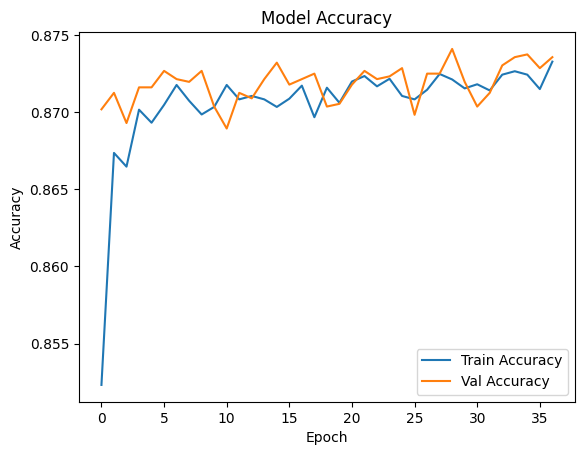

In [38]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [52]:
df_test

,ID,Date,X1,X2,X3,X4,X5,day,month,year,dayofweek,is_weekend
0,0,2020-12-16,1.685395,5.463917,1.0,7.389056,2.890372,16,12,2020,2,0
1,1,2020-12-16,1.488844,5.454936,1.0,7.389056,2.890372,16,12,2020,2,0
2,2,2020-12-16,1.164160,5.471136,1.0,1.000000,2.890372,16,12,2020,2,0
3,3,2020-12-16,1.000000,5.467385,1.0,1.000000,2.890372,16,12,2020,2,0
4,4,2020-12-16,1.000000,5.453995,1.0,1.000000,2.833213,16,12,2020,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
409851,409851,2024-11-26,1.120752,5.483053,1.0,2.718282,0.000000,26,11,2024,1,0
409852,409852,2024-11-26,1.096365,5.477802,1.0,7.389056,0.000000,26,11,2024,1,0
409853,409853,2024-11-26,1.111822,5.479972,1.0,2.718282,0.000000,26,11,2024,1,0
409854,409854,2024-11-26,1.000000,5.486165,1.0,1.000000,0.000000,26,11,2024,1,0


# Preprocessing the 'test' file

In [41]:
# Feature engineering (same as train)
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test['day'] = df_test['Date'].dt.day
df_test['month'] = df_test['Date'].dt.month
df_test['year'] = df_test['Date'].dt.year
df_test['dayofweek'] = df_test['Date'].dt.dayofweek
df_test['is_weekend'] = (df_test['dayofweek'] >= 5).astype(int)

In [42]:
# Select numeric features (drop target if mistakenly present)
df_test_numeric = df_test.select_dtypes(include='number')

In [51]:
df_test_numeric

,ID,X1,X2,X3,X4,X5,day,month,year,dayofweek,is_weekend
0,0,1.685395,5.463917,1.0,7.389056,2.890372,16,12,2020,2,0
1,1,1.488844,5.454936,1.0,7.389056,2.890372,16,12,2020,2,0
2,2,1.164160,5.471136,1.0,1.000000,2.890372,16,12,2020,2,0
3,3,1.000000,5.467385,1.0,1.000000,2.890372,16,12,2020,2,0
4,4,1.000000,5.453995,1.0,1.000000,2.833213,16,12,2020,2,0
...,...,...,...,...,...,...,...,...,...,...,...
409851,409851,1.120752,5.483053,1.0,2.718282,0.000000,26,11,2024,1,0
409852,409852,1.096365,5.477802,1.0,7.389056,0.000000,26,11,2024,1,0
409853,409853,1.111822,5.479972,1.0,2.718282,0.000000,26,11,2024,1,0
409854,409854,1.000000,5.486165,1.0,1.000000,0.000000,26,11,2024,1,0


In [43]:
# Drop same columns as train
features_to_drop = ['month', 'day', 'is_weekend', 'dayofweek', 'year','ID']
X_final_test = df_test_numeric.drop(columns=features_to_drop, errors='ignore')

# Scale using the same scaler fitted on training data
X_final_test_scaled = scaler.transform(X_final_test)

In [50]:
X_final_test

,X1,X2,X3,X4,X5
0,1.685395,5.463917,1.0,7.389056,2.890372
1,1.488844,5.454936,1.0,7.389056,2.890372
2,1.164160,5.471136,1.0,1.000000,2.890372
3,1.000000,5.467385,1.0,1.000000,2.890372
4,1.000000,5.453995,1.0,1.000000,2.833213
...,...,...,...,...,...
409851,1.120752,5.483053,1.0,2.718282,0.000000
409852,1.096365,5.477802,1.0,7.389056,0.000000
409853,1.111822,5.479972,1.0,2.718282,0.000000
409854,1.000000,5.486165,1.0,1.000000,0.000000


# Generating results on 'test' file for each model

In [53]:
# Logistic Regression
y_probs_lr = lr_model.predict_proba(X_final_test_scaled)[:, 1]
y_pred_lr_final = (y_probs_lr >= 0.3).astype(int)

submission_lr = pd.DataFrame({
    'ID': df_test['ID'],
    'target': y_pred_lr_final
})
submission_lr.to_csv('submission_logistic_regression.csv', index=False)

In [54]:
# Support Vector Machine
y_probs_svm = svm_model.predict_proba(X_final_test_scaled)[:, 1]
y_pred_svm_final = (y_probs_svm >= 0.3).astype(int)

submission_svm = pd.DataFrame({
    'ID': df_test['ID'],
    'target': y_pred_svm_final
})
submission_svm.to_csv('submission_svm.csv', index=False)

In [55]:
# K-Nearest Neighbors
y_probs_knn = knn_model.predict_proba(X_final_test_scaled)[:, 1]
y_pred_knn_final = (y_probs_knn >= 0.3).astype(int)

submission_knn = pd.DataFrame({
    'ID': df_test['ID'],
    'target': y_pred_knn_final
})
submission_knn.to_csv('submission_knn.csv', index=False)

In [56]:
# Decision Tree
y_probs_dt = dt_model.predict_proba(X_final_test_scaled)[:, 1]
y_pred_dt_final = (y_probs_dt >= 0.3).astype(int)

submission_dt = pd.DataFrame({
    'ID': df_test['ID'],
    'target': y_pred_dt_final
})
submission_dt.to_csv('submission_decision_tree.csv', index=False)

In [57]:
# Random Forest
y_probs_rf = rf_model.predict_proba(X_final_test_scaled)[:, 1]
y_pred_rf_final = (y_probs_rf >= 0.3).astype(int)

submission_rf = pd.DataFrame({
    'ID': df_test['ID'],
    'target': y_pred_rf_final
})
submission_rf.to_csv('submission_random_forest.csv', index=False)

In [58]:
# LightGBM
y_probs_lgbm = lgbm_model.predict_proba(X_final_test_scaled)[:, 1]
y_pred_lgbm_final = (y_probs_lgbm >= 0.3).astype(int)

submission_lgbm = pd.DataFrame({
    'ID': df_test['ID'],
    'target': y_pred_lgbm_final
})
submission_lgbm.to_csv('submission_lightgbm.csv', index=False)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [59]:
# XGBoost
y_probs_xgb = model.predict_proba(X_final_test_scaled)[:, 1]
y_pred_xgb_final = (y_probs_xgb >= 0.3).astype(int)

submission_xgb = pd.DataFrame({
    'ID': df_test['ID'],
    'target': y_pred_xgb_final
})
submission_xgb.to_csv('submission_xgboost.csv', index=False)

In [61]:
# Neural Network
y_probs_nn = dl_model.predict(X_final_test_scaled).flatten()
y_pred_nn_final = (y_probs_nn >= 0.3).astype(int)

submission_nn = pd.DataFrame({
    'ID': df_test['ID'],
    'target': y_pred_nn_final
})
submission_nn.to_csv('submission_neural_net.csv', index=False)

12808/12808 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step


# Checking information from submission file

In [62]:
df_sample_submission

,ID,target
0,409856,0
1,409857,0
2,409858,0
3,409859,0
4,409860,0
5,409861,0
6,409862,0
7,409863,0
8,409864,0
9,409865,0


In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [67]:
y_pred_lr   = lr_model.predict(X_test)
y_pred_svm  = svm_model.predict(X_test)
y_pred_knn  = knn_model.predict(X_test)
y_pred_dt   = dt_model.predict(X_test)
y_pred_rf   = rf_model.predict(X_test)
y_pred_lgbm = lgbm_model.predict(X_test)
y_pred_xgb  = model.predict(X_test)
y_pred_dl   = dl_model.predict(X_test) > 0.3  # ANN thresholded
y_pred_dl   = y_pred_dl.astype(int).flatten()

 87/176 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


# Priting results of all models together

In [71]:
results = {
    "Model": ["Logistic Regression", "SVM", "KNN", "Decision Tree", "Random Forest", "LightGBM", "XGBoost", "Deep Learning"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_svm),
        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_lgbm),
        accuracy_score(y_test, y_pred_xgb),
        accuracy_score(y_test, y_pred_dl)
    ],
    "F1 Score (macro)": [
        f1_score(y_test, y_pred_lr, average='macro'),
        f1_score(y_test, y_pred_svm, average='macro'),
        f1_score(y_test, y_pred_knn, average='macro'),
        f1_score(y_test, y_pred_dt, average='macro'),
        f1_score(y_test, y_pred_rf, average='macro'),
        f1_score(y_test, y_pred_lgbm, average='macro'),
        f1_score(y_test, y_pred_xgb, average='macro'),
        f1_score(y_test, y_pred_dl, average='macro')
    ]
}

results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df.sort_values(by="F1 Score (macro)", ascending=False))


Model Comparison:
                 Model  Accuracy  F1 Score (macro)
5             LightGBM  0.908298          0.908296
6              XGBoost  0.884793          0.884789
0  Logistic Regression  0.870905          0.870893
1                  SVM  0.870192          0.870157
2                  KNN  0.866809          0.866798
4        Random Forest  0.862892          0.862877
7        Deep Learning  0.855591          0.854551
3        Decision Tree  0.832621          0.832619


# Hyperparameter tuning

In [85]:
# Define the model
rf = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, scoring='f1_macro', n_jobs=1, verbose=1)

# Fit to training data
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Macro Score:", grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Best F1 Macro Score: 0.8808988989221884
